In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using UMAP, Muon
using Distances
using SPI
using DataFrames, CSV
using StatsBase
using StatsPlots
theme(:default, grid=false, framestyle=:box, label="", ratio=1)

In [2]:
ddir = datadir("exp_pro", "BB728")
rdir = projectdir("_research", "UMAPof356isolates") |> mkpath
pdir = plotsdir("UMAPof356isolates") |> mkpath
biobank = readh5mu(joinpath(ddir, "BB728.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/ben/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 728 ✕ 21485
└ metabolites_foldchange
  AnnData object 728 ✕ 50
└ metabolites_millimolar
  AnnData object 728 ✕ 10
└ UPorder_oggs
  AnnData object 728 ✕ 10177
└ oggs
  AnnData object 728 ✕ 11248

In [3]:
mtx = biobank["UPorder_oggs"].X[:,:];

In [5]:
trn_mask = biobank.obs.inBB673 .== 1
tst_mask = biobank.obs.inBB673 .== 0
trn_mtx = biobank["UPorder_oggs"].X[:,:][trn_mask, :]
tst_mtx = biobank["UPorder_oggs"].X[:,:][tst_mask, :];
mtx = biobank["UPorder_oggs"].X[:,:];

In [6]:
bb_met_lfc = biobank["metabolites_foldchange"].X[:, :];
bb_met_lfc[isinf.(bb_met_lfc)] .= 0.0;
metabolicdistance = pairwise(Euclidean(), bb_met_lfc; dims=1);

metabolicallyvariabledf = biobank.obs[trn_mask, :] |>
    df->DataFrames.transform(df, eachindex => :rowid) |>
    df->groupby(df, :species) |>
    df->combine(df, 
        nrow => :num_isolates, 
        :rowid => ((x)->maximum(metabolicdistance[x,x])) => :max_metabolicdistance,
        :rowid => ((x)->maximum(metabolicdistance[x,x]) > 20) => :isvariable,
        ) |>
    df->filter(:num_isolates => >=(10), df) |>
    df->sort(df, [:max_metabolicdistance, :num_isolates], rev=true)

specieswith20reps = metabolicallyvariabledf |>
    df -> filter(:num_isolates => >=(20), df) |>
    df -> filter(:species => !=("unclassified"), df) |>
    df -> sort(df, :num_isolates, rev=true)


spe20rep_mask = .!isnothing.(indexin(biobank.obs.species[trn_mask], specieswith20reps.species));

In [7]:
full_train_mask = zeros(Bool, 728)
full_train_mask[trn_mask] .= spe20rep_mask;

full_test_mask = ones(Bool, 728)
full_test_mask[trn_mask] = .!spe20rep_mask
sum(full_train_mask), sum(full_test_mask)

(356, 372)

In [22]:
bbobs_trn = biobank.obs[full_train_mask, :];
# bbobs_trn = biobank.obs[trn_mask, :];
# correct missing Family annotation
bbobs_trn.family[bbobs_trn.species .== "Phocaeicola vulgatus"] .= "Bacteroidaceae";
bbobs_trn[bbobs_trn.family .== "", [:ID, :phylum, :class, :order, :family, :genus, :species]];
bbobs_trn.family[bbobs_trn.family .== ""] .= "Unknown";

In [9]:
bbusv = SVD(
    biobank["UPorder_oggs"].obsm["inferredLSVs"][:,:],
    biobank["UPorder_oggs"].uns["UP_SVs"][:],
    biobank["UPorder_oggs"].varm["UP_RSVs"][:, :]',
    );
norm(mtx .- projectout(bbusv)) / norm(mtx)

0.03065109952898508

In [10]:
donorid = split.(bbobs_trn.ID, ".") |>
    x->getindex.(x, Ref(1:2)) |>
    x->join.(x, ".")
bbobs_trn[!, :donor_id] = donorid;

In [16]:
csb_mtx = biobank["oggs"].X[:,:][full_train_mask, :]
# csb_mtx = biobank["oggs"].X[:,:][trn_mask, :]
bbusv_csb = svd(csb_mtx);

In [17]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100

356-element Vector{Float64}:
 72.90772001602632
 15.601476830889299
  2.0554948630499212
  1.4622201058219653
  1.2570900078906357
  0.9523060853826324
  0.9083780430502364
  0.7193349098629979
  0.4186621536380066
  0.35690892843254446
  ⋮
  6.617417843096761e-31
  6.617417843096761e-31
  6.617417843096761e-31
  6.617417843096761e-31
  6.617417843096761e-31
  6.617417843096761e-31
  6.617417843096761e-31
  6.617417843096761e-31
  6.617417843096761e-31

In [18]:
sum(pctvar[1:3])

90.56469170996553

In [19]:
sum(pctvar[1:10])

96.63959194404455

In [29]:
sum(contains.(bbobs_trn.species, "hadrus"))

31

In [17]:
# specieslabels = [
#     "Bacteroides uniformis",
#     "Phocaeicola vulgatus",
#     "Bacteroides thetaiotaomicron",
#     "[Ruminococcus] gnavus",
#     "Bifidobacterium breve",
#     "[Eubacterium] rectale",
#     "Dorea formicigenerans",
#     "Coprococcus comes",
#     "Blautia luti & Blautia wexlerae",
#     "Anaerostipes hadrus",
# ]
# shapes = permutedims([:circle, :rect, :star5, :diamond, :hexagon, :ltriangle, :pentagon, :utriangle, :dtriangle, :rtriangle, :star4])
# speciescolors = wload(joinpath(ddir, "subsettreecolors.jld2"))["colors"]
# speciescolors_ordered = permutedims(speciescolors[replace(indexin(sort(unique(bbobs_trn.species)), specieslabels), nothing=>9)])

In [54]:
sortperm(unique(bbobs_trn.family))

11-element Vector{Int64}:
  5
  1
 10
 11
  4
  2
  9
  3
  8
  6
  7

In [87]:
orderedfamilylabels = names(sort(countmap(bbobs_trn.family), byvalue=true, rev=true))
indexin(sort(unique(bbobs_trn.family)), orderedfamilylabels)

familycolors = permutedims(palette(:Set3_11).colors.colors[indexin(sort(unique(bbobs_trn.family)), orderedfamilylabels)])

## Original matrix

In [47]:
orig_coords = umap(float.(csb_mtx)', 2; n_neighbors=size(csb_mtx, 1)-1, metric=Euclidean())';

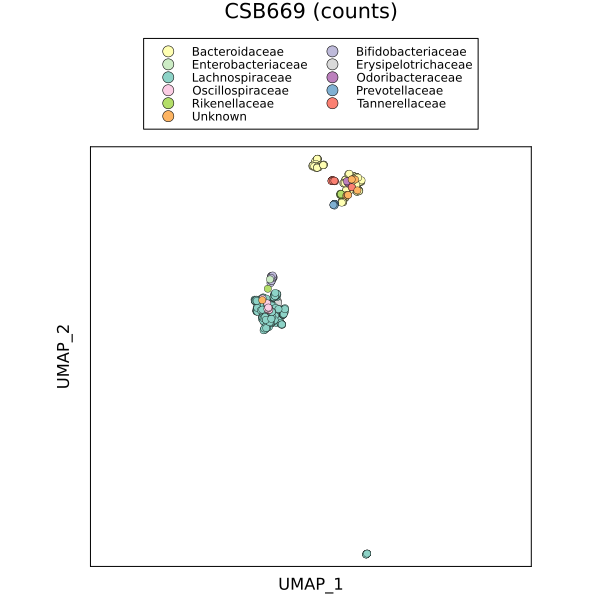

In [88]:
scatter(orig_coords[:, 1], orig_coords[:, 2],
    group=bbobs_trn.family,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=familycolors,
    ticks=:none,
    title="CSB669 (counts)",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [100]:
savefig(joinpath(pdir, "umap_counts_356isolates_byspecies.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof356isolates/umap_counts_356isolates_byspecies.pdf"

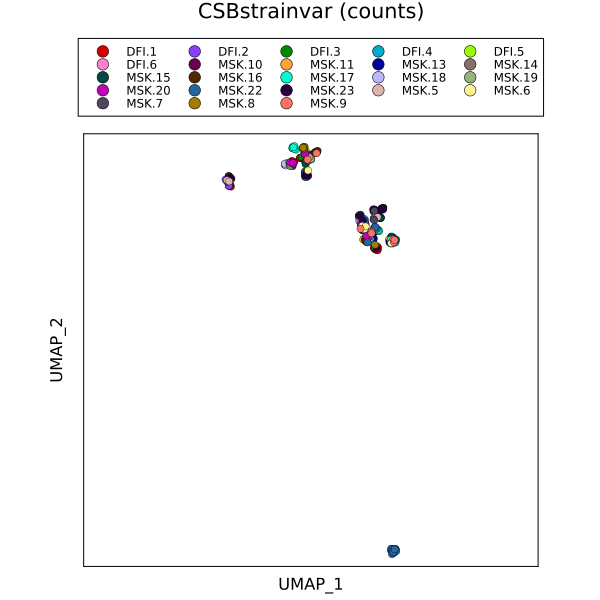

In [103]:
scatter(orig_coords[:, 1], orig_coords[:, 2],
    group=bbobs_trn.donor_id,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="CSBstrainvar (counts)",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [104]:
savefig(joinpath(pdir, "umap_counts_356isolates_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof356isolates/umap_counts_356isolates_bydonor.pdf"

## Top PCs

In [74]:
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S)
pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=355, metric=Euclidean())';

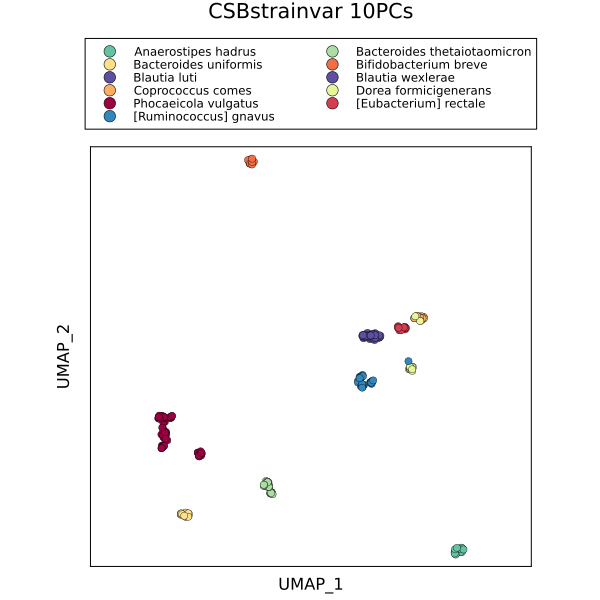

In [93]:
scatter(pcs_coords[:, 1], pcs_coords[:, 2],
    group=bbobs_trn.species,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=speciescolors_ordered,
    ticks=:none,
    title="CSBstrainvar 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [94]:
savefig(joinpath(pdir, "umap_top10PCs_356isolates_byspecies.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof356isolates/umap_top10PCs_356isolates_byspecies.pdf"

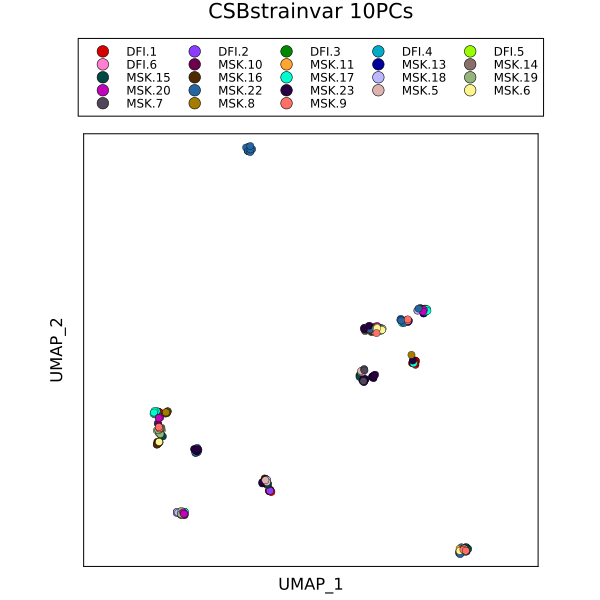

In [95]:
scatter(pcs_coords[:, 1], pcs_coords[:, 2],
    group=bbobs_trn.donor_id,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="CSBstrainvar 10PCs",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [96]:
savefig(joinpath(pdir, "umap_top10PCs_356isolates_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof356isolates/umap_top10PCs_356isolates_bydonor.pdf"

## PC plots

In [114]:
pctvar = SPI.explainedvariance(bbusv_csb.S) .* 100;

In [ ]:
pcs_csb = bbusv_csb.U * diagm(bbusv_csb.S)
# pcs_coords = umap(pcs_csb[:, 1:10]', 2; n_neighbors=355, metric=Euclidean())';

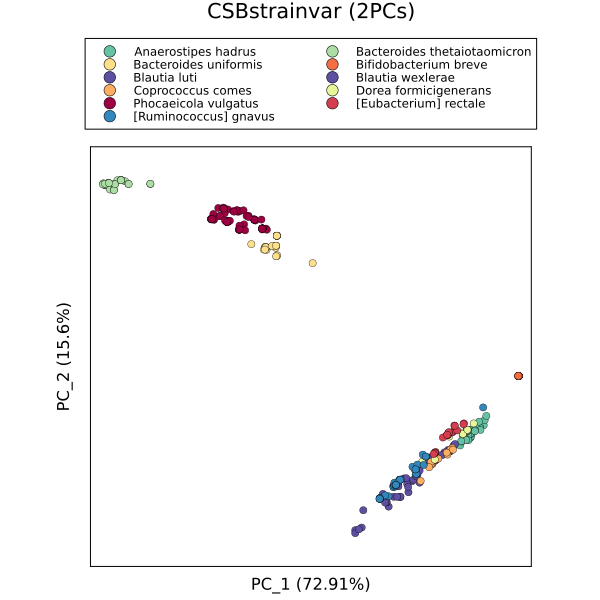

In [120]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=bbobs_trn.species,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=speciescolors_ordered,
    ticks=:none,
    title="CSBstrainvar (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [121]:
savefig(joinpath(pdir, "PCplot_PCs1and2_356isolates_byspecies.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof356isolates/PCplot_PCs1and2_356isolates_byspecies.pdf"

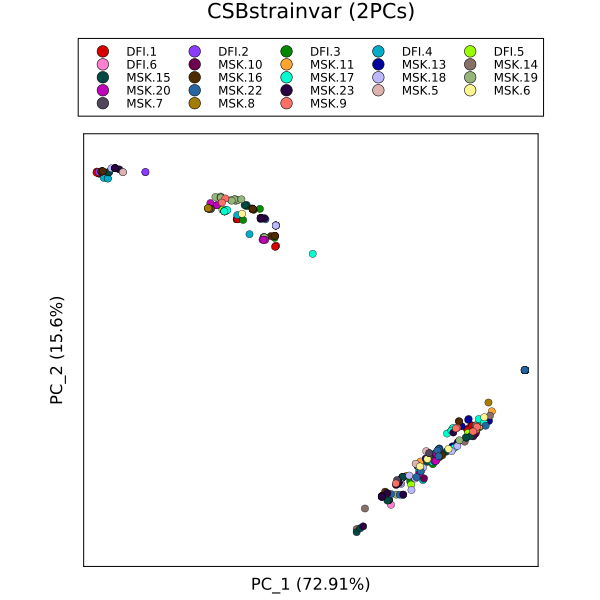

In [123]:
scatter(pcs_csb[:, 1], pcs_csb[:, 2],
    group=bbobs_trn.donor_id,
    alpha=1, markerstrokewidth=.3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="CSBstrainvar (2PCs)",
    xlabel="PC_1 ($(round(pctvar[1], digits=2))%)",
    ylabel="PC_2 ($(round(pctvar[2], digits=2))%)",
)

In [124]:
savefig(joinpath(pdir, "PCplot_PCs1and2_356isolates_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof356isolates/PCplot_PCs1and2_356isolates_bydonor.pdf"

## SPI distance

In [84]:
SDij = biobank["UPorder_oggs"].obsp["SDij"][:,:][full_train_mask, full_train_mask]
spi_coords = umap(SDij, 2; n_neighbors=355, metric=:precomputed)';

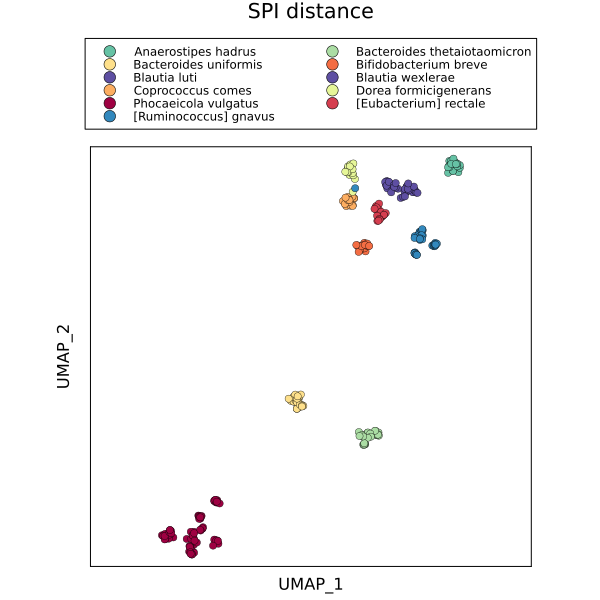

In [132]:
scatter(spi_coords[:, 1], spi_coords[:, 2],
    group=bbobs_trn.species,
    alpha=1, markerstrokewidth=.3,
    # markersize=3,
    size=(600,600),
    legend=:outertop,
    legendcolumns=2,
    c=speciescolors_ordered,
    ticks=:none,
    title="SPI distance",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [133]:
savefig(joinpath(pdir, "umap_spidistance_356isolates_byspecies.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof356isolates/umap_spidistance_356isolates_byspecies.pdf"

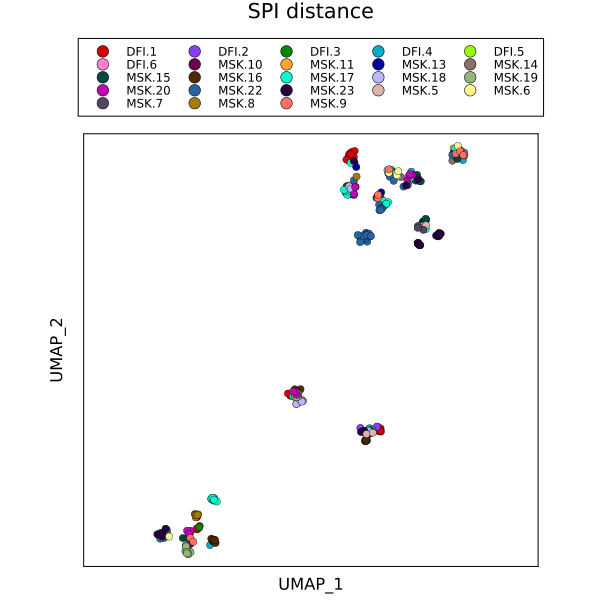

In [134]:
scatter(spi_coords[:, 1], spi_coords[:, 2],
    group=bbobs_trn.donor_id,
    alpha=1, markerstrokewidth=.3,
    # markersize=2,
    size=(600,600),
    legend=:outertop,
    legendcolumns=5,
    c=permutedims(palette(:glasbey_bw_n256).colors.colors),
    ticks=:none,
    title="SPI distance",
    xlabel="UMAP_1",
    ylabel="UMAP_2",
)

In [135]:
savefig(joinpath(pdir, "umap_spidistance_356isolates_bydonor.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/UMAPof356isolates/umap_spidistance_356isolates_bydonor.pdf"